# Android Malware Detection


**Machine Learning (ML)** systems are nowadays being extensively used as the core components of many systems, including malware detectors. Despite the impressive performances reported by such systems on benchmark datasets, the problem of detection in the wild is still far from being solved. In fact, many of these algorithms were not designed to cope with Adversarial Examples.

In this tutorial, we show how to use SecML to build, explain, attack and evaluate the security of a malware detector for Android applications, based on a *linear Support Vector Machine (SVM)*, a common choice for this task given its performance and the interpretability of its decisions.

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

We start by loading a toy dataset of Android applications, named `DrebinRed`, consisting of **12,000** benign and **550** malicious samples extracted from the Drebin dataset:

[arp2014drebin] Arp, Daniel, et al. "Drebin: Effective and explainable detection of android malware in your pocket." NDSS. Vol. 14. 2014.

See https://www.sec.cs.tu-bs.de/~danarp/drebin/ to obtain the full version.

In [2]:
# NBVAL_IGNORE_OUTPUT
import re
import secml
from secml import settings
from secml.utils import fm
from secml.utils.download_utils import dl_file_gitlab

repo_url = 'https://gitlab.com/secml/secml-zoo'
file_name = 'drebin-reduced.tar.gz'
file_path = 'datasets/DrebinRed/' + file_name
output_dir = fm.join(settings.SECML_DS_DIR, 'drebin-red')
md5_digest = 'ecf87ddedf614dd53b89285c29cf1caf'

ds_path = fm.join(output_dir, file_name)

# The following tries to get the correct dataset for the current library version
if not fm.file_exist(ds_path):
    try:
        # Try downloading from the branch corresponding to current version
        min_version = re.search(r'^\d+.\d+', secml.__version__).group(0)
        dl_file_gitlab(repo_url, file_path, output_dir,
                       branch='v' + min_version, md5_digest=md5_digest)

    except Exception as e:  # Try looking into 'master' branch...
        dl_file_gitlab(repo_url, file_path, output_dir, md5_digest=md5_digest)

In [3]:
from secml.utils import pickle_utils

ds = pickle_utils.load(ds_path)

print("Num. samples: ", ds.num_samples)

n_neg = sum(ds.Y == 0)
n_pos = sum(ds.Y == 1)

print("Num. benign samples: ", n_neg)
print("Num. malicious samples: ", n_pos)

print("Num. features: ", ds.num_features)

Num. samples:  12550
Num. benign samples:  12000
Num. malicious samples:  550
Num. features:  1227080


# Training and testing the detector

We train the Support Vector Machine classifier on half the dataset, while using the rest for testing. The performance on the task of recognizing benign and malicious applications will be reported by means of the Detection `Rate @ 2%` False Positive Rate, the `F1 score` and by plotting the **Receiver Operating Characteristic (ROC)** curve.

In [4]:
import re
import secml
from secml import settings
from secml.utils import fm
from secml.utils.download_utils import dl_file_gitlab
from secml.utils import pickle_utils
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, TwoLocal, RealAmplitudes
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.algorithms.optimizers import COBYLA,SPSA
from qiskit_machine_learning.algorithms import VQC
seed=10599
from qiskit import BasicAer
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

In [5]:
from secml.ml.features import CNormalizerMinMax
from secml.ml.classifiers import CClassifier
from secml.data.splitter import CTrainTestSplit
from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy

In [6]:
import time
start_time = time.time()

In [7]:
# create a new dataset object with only the first two features
ds = ds[:, :100000]

In [8]:
# split the dataset into training and test sets
tr, ts = CTrainTestSplit(train_size=6000, random_state=0).split(ds)

In [9]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.opflow import Z, StateFn
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QSVC
from qiskit import QuantumCircuit
# Define the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=ds.num_features, reps=2)

# Define the quantum circuit for the kernel
ansatz = TwoLocal(num_qubits=ds.num_features, rotation_blocks=['ry'], entanglement_blocks='cz', reps=1)


# Define the quantum instance to run the circuit on a simulator
qi = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                     shots=1024,
                     seed_simulator=0,
                     seed_transpiler=0)
optimizer = SPSA()

In [10]:
# Define VQC instance with SVM classifier and COBYLA optimizer
vqc_estimator = VQC(feature_map=feature_map, ansatz=ansatz, loss="cross_entropy", optimizer=optimizer, quantum_instance = qi)

In [11]:
clf = vqc_estimator

In [12]:
print("Training started...")
clf.fit(tr.X, tr.Y)#clf.fit(tr.X, tr.Y)
print("Training completed!")

Training started...
Training completed!


In [13]:
# Classification of test set and computation of performance metrics
y_pred, score_pred = clf.predict(ts.X, return_decision_function=True)

from secml.ml.peval.metrics import CMetricTPRatFPR, CMetricF1, CRoc

fpr_th = 0.02  # 2% False Positive Rate

dr = CMetricTPRatFPR(fpr=fpr_th).performance_score(y_true=ts.Y, score=score_pred[:, 1].ravel())
print("Detection rate @ 2% FPR: {:.2%}".format(dr))

f1 = CMetricF1().performance_score(y_true=ts.Y, y_pred=y_pred)
print("F1 score: {:.2%}".format(f1))

Detection rate @ 2% FPR: 71.63%
F1 score: 52.93%


2023-03-01 21:51:09,505 - py.warnings - WARNING - C:\Anaconda_py\envs\qiskitty\lib\site-packages\secml\figure\_plots\c_plot.py:1309: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  self._sp.set_xlim(bottom, top)



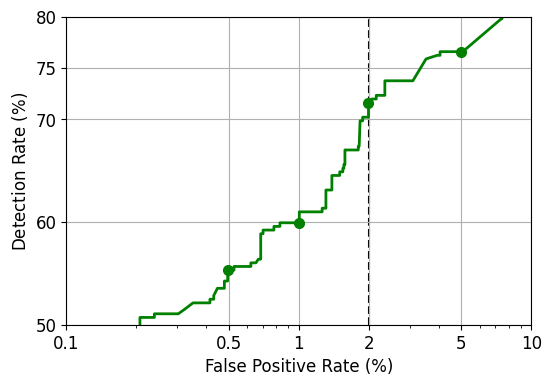

In [14]:
fpr, tpr, _ = CRoc().compute(y_true=ts.Y, score=score_pred[:, 1].ravel())

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4, width=6)
fig.sp.plot_roc(fpr, tpr)
fig.sp._sp.axvline(x=2, c='k', linestyle='--', zorder=-1)
fig.sp.xlim(0, 10)
fig.sp.ylim(50, 80)
fig.sp.yticks([50, 60, 70, 75, 80])
fig.sp.yticklabels([50, 60, 70, 75, 80])
fig.sp.ylabel(r'Detection Rate $(\%)$')

# Explaining the decisions

In this section of the tutorial, we compute the post-hoc explanations for the trained Android malware detector by analyzing the trained model to understand which components of the applications are more relevant during the decision (classification) phase.

We use the **Gradient * Input** gradient-based explanation method, which is implemented by the `CExplainerGradientInput` class. Our algorithm is optimized to run on sparse data, which makes it suitable to be used in this application example.

For each sample, one benign and one malicious, we compute the explanations with respect to the positive (malicious) class and list the top-10 influential features, along with the corresponding relevance (%).


In [15]:
from secml.explanation import CExplainerGradientInput

expl = CExplainerGradientInput(clf)

print("Computing explanations using '{:}'".format(expl.__class__.__name__))

Computing explanations using 'CExplainerGradientInput'


In [16]:
# Explanations for a benign sample
i = 137
x, y = ts[i, :].X, ts[i, :].Y

print("Explanations for sample {:} (true class: {:})".format(i, y.item()))

attr = expl.explain(x, y=1)
attr = attr / attr.norm(order=1)  # To display values in 0-100

attr_argsort = abs(attr).argsort().ravel()[::-1]

n_plot = 10

for i in attr_argsort[:10]:
    print("{:6.2f}\t{:}".format(attr[i].item() * 100, ds.header.feat_desc[i]))

Explanations for sample 137 (true class: 0)
-32.66	suspicious_calls::android/net/Uri;->isHierarchical
-23.11	urls::csi.cauly.co.kr:1109
-16.36	suspicious_calls::android/net/Uri;->parse
-13.93	urls::http://www.googleadservices.com/pagead/aclk
-13.93	urls::http://googleads.g.doubleclick.net
 -0.01	req_permissions::android.permission.ACCESS_NETWORK_STATE
  0.00	activities::com.appsbar.DemunJones18305.events.EventsMonthView
  0.00	activities::com.pocketattorney.WillStrusts
  0.00	receivers::it.mp.widget.meteolive.MeteoLiveAppWidgetProvider
  0.00	activities::com.wanju.tour.space2


Looking at the first sample, a benign application, we can observe how the majority of the features have a negative relevance towards the decision, meaning that, for this classifier, are an indication of a benign behavior.

Regarding the second sample, a malicious application, we can observe the opposite, as the majority of the features have a positive relevance value, meaning that, for this classifier, are an indication of a malicious behavior.

We also observe that more than **~50%** of the relevance is assigned to only **10 features** in both cases. This highlights a known behavior of these classifiers, which tend to assign most of the weight to a small set of features, making them vulnerable to adversarial evasion attacks.

# Crafting Adversarial Examples

We now set up a gradient-based maximum-confidence evasion attack to create adversarial examples against the SVM classifier on which the Android malware detector is based on.

Firstly, we choose the solver parameters. As we are working with boolean features (each can take either 0 or 1 value), we use a line search grid step `eta` of 1. Then, we choose `l1` as the distance, in order to perform a L1-order sparse attack, were only one feature is changed (from 0 to 1 or vice-versa) at each iteration. Finally, as we only want malicious samples to be classified as benign, we set `y_target` = 0 to perform a targeted attack.

The lower and the upper bound constraints are critical in this application. To create malware able to fool a classifier, an attacker may, in theory, both adding and removing features from the original applications. However, in practice, feature removal is a non-trivial operation that can easily compromise the malicious functionalities of the application and, generally speaking, only be performed for `not-manifest` components. Feature addition is a safer operation, especially when the injected features belong to the manifest; for example, adding permissions does not influence any existing application functionality.

Therefore, in this example, to only alow feature addition we set `lb = 'x0'` and `ub = 1`. To also allow feature removal, one can set `lb = 0`.

In [17]:
# Attack parameters
params = {
    "classifier": clf,
    "distance": 'l1',
    "double_init": False,
    "lb": 'x0',
    "ub": 1,
    "attack_classes": 'all',
    "y_target": 0,
    "solver_params": {'eta': 1, 'eta_min': 1, 'eta_max': None, 'eps': 1e-4}
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS

evasion = CAttackEvasionPGDLS(**params)

# Security Evaluation

To evaluate the robustness of the Android malware detector against increasing number of modified (added) features, SecML provides a way to easily produce a **Security Evaluation Curve, by means of the** `CSecEval class`.

The `CSecEval` instance will run the evasion attack on the classifier using increasing values of the L1-order perturbation `eps`.

This process should last **around 60 seconds**, despite working on over 1 million features, using the `CAttackEvasionPGDLS` attack, as it is optimized to run on sparse data.

In [18]:
n_mal = 10

# Attack DS
mal_idx = ts.Y.find(ts.Y == 1)[:n_mal]
adv_ds = ts[mal_idx, :]

# Security evaluation parameters
param_name = 'dmax'  # This is the `eps` parameter
dmax_start = 0.1  # Start value adjusted based on F1 score
dmax = 5  # Stop value adjusted based on F1 score
dmax_step = 0.5  # Step value adjusted based on F1 score

from secml.array import CArray

param_values = CArray.arange(
    start=dmax_start, step=dmax_step, stop=dmax + dmax_step)

from secml.adv.seceval import CSecEval

sec_eval = CSecEval(
    attack=evasion,
    param_name=param_name,
    param_values=param_values)

print("Running security evaluation...")
sec_eval.run_sec_eval(adv_ds)
print("Security evaluation completed!")

Running security evaluation...
Security evaluation completed!


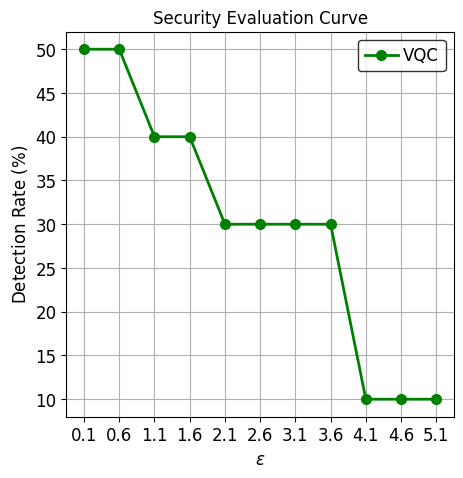

In [19]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

from secml.ml.peval.metrics import CMetricTHatFPR, CMetricTPRatTH

# Get the ROC threshold at which Detection Rate should be computed
th = CMetricTHatFPR(fpr=fpr_th).performance_score(y_true=ts.Y, score=score_pred[:, 1].ravel())

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, metric=CMetricTPRatTH(th=th),
                     percentage=True, label='VQC', color='green', marker='o')
fig.sp.ylabel(r'Detection Rate $(\%)$')
fig.sp.xlabel(r"$\varepsilon$")

We can see how this malware detector based on the SVM classifier is vulnerable to adversarial attacks and after changing less than 10 features half of the malicious samples are incorrectly classified as benign applications. This known vulnerability has also been **highlighted** when we listed the top influential features and observed that most of the relevance is given to a very limited set of features.

In [20]:
end_time = time.time()

In [21]:
computation_time = end_time - start_time

print("Computation time: {:.2f} seconds".format(computation_time))

Computation time: 38.69 seconds
